In [80]:
# Import required libraries
import os
import numpy as np

from PIL import Image
from keras import backend as K
from keras.models import load_model
from matplotlib.pyplot import imshow

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
[[0.57273  0.677385]
 [1.87446  2.06253 ]
 [3.33843  5.47434 ]
 [7.88282  3.52778 ]
 [9.77052  9.16828 ]]


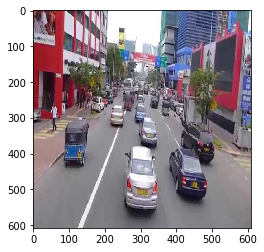

In [81]:
# read the model / setup files

# Read labels file
labels_path = 'model/labels.txt'
with open(labels_path) as f:
    label_names = f.readlines()
label_names = [n.strip() for n in label_names]
print(label_names)

# Read anchor boxes file
anchors_path = 'model/yolo_anchor_boxes.txt'
with open(anchors_path) as f:
    anchor_boxes = f.readline()
    anchor_boxes = [float(b) for b in anchor_boxes.split(',')]
anchor_boxes = np.array(anchor_boxes).reshape(-1, 2)
print(anchor_boxes)

# Read Input Image
input_image = Image.open('data/test.jpg')
input_resize = input_image.resize([608, 608], Image.BICUBIC)
imshow(input_image)
imshow(input_resize)
input_resize.save('data/test_resize.jpg')


In [82]:

#Load the pretrained model
yolo_model = load_model("model/yolov2.h5")

# summery of the model
yolo_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

In [84]:
# Convert output to bounding boxes
# The below functions from the yad2k library will be used
from yad2k.models.keras_yolo import yolo_head, yolo_eval

# Function to convert features to bounding boxes
def yolo_output(features, anchor_boxes, labels):
    '''
    Input: features - output of networks
           anchor boxes - widht & height
           labels   
    Output: co-ordinates (x,y) of the box
            widht, height of the anchor box
            confidence if the box contains object
            confidence of that box has specified label object
    '''
    num_anchor_boxes = len(anchor_boxes)


#Convert final layer features to bounding box parameters
yolo_outputs = yolo_head(yolo_model.output, anchor_boxes, len(label_names))

# Now yolo_eval function selects the best boxes using filtering and non-max suppression techniques.
# If you want to dive in more to see how this works, refer keras_yolo.py file in yad2k/models
image_shape = np.array(input_image.size, dtype=float)
boxes, scores, labels = yolo_eval(yolo_outputs, image_shape)

Found 6 boxes for test.jpg


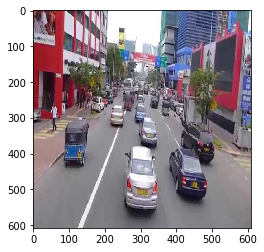

In [85]:
# Run the tensorflow session
from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes

# Initiate a session
sess = K.get_session()

#Preprocess the input image before feeding into the convolutional network
image, image_data = preprocess_image('data/test.jpg', model_image_size = (608, 608))

imshow(image)

#Run the session
out_scores, out_boxes, out_labels = sess.run([scores, boxes, labels],feed_dict={yolo_model.input:image_data,K.learning_phase(): 0})

#Print the results
print('Found {} boxes for {}'.format(len(out_boxes), 'test.jpg'))


person 0.60 (49, 259) (70, 339)
car 0.70 (216, 264) (253, 322)
car 0.70 (299, 297) (348, 376)
car 0.71 (421, 322) (512, 426)
car 0.81 (377, 385) (491, 525)
car 0.84 (256, 381) (350, 553)


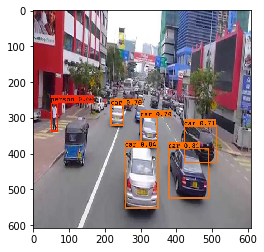

In [86]:
import scipy

#Produce the colors for the bounding boxs
colors = generate_colors(label_names)
#Draw the bounding boxes
image_resize = image.resize([608, 608])
draw_boxes(image_resize, out_scores, out_boxes, out_labels, label_names, colors)
#Apply the predicted bounding boxes to the image and save it
image_resize.save(os.path.join("out", 'test.jpg'), quality=90)
#output_image = scipy.misc.imread(os.path.join("out", 'test.jpg'))
output_image = Image.open(os.path.join("out", 'test.jpg'))
imshow(output_image)